In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from transformers import ViTImageProcessor, ViTForImageClassification
from sklearn.metrics import classification_report
from tqdm import tqdm
import torch

# Enable mixed precision for better GPU performance
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Configure GPU settings
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# Dataset paths
train_dir = '/kaggle/input/lcc-fasd/LCC_FASD/LCC_FASD_training'
val_dir = '/kaggle/input/lcc-fasd/LCC_FASD/LCC_FASD_evaluation'

# Data augmentation and normalization
datagen = ImageDataGenerator(rescale=1./255)

# Data generator
train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

# Function to filter data
def filter_data(generator, spoof_count, real_count):
    images, labels = [], []
    for batch_images, batch_labels in tqdm(generator):
        for img, label in zip(batch_images, batch_labels):
            if label == 0 and len(images) < spoof_count:
                images.append(img)
                labels.append(label)
            elif label == 1 and len(images) < (spoof_count + real_count):
                images.append(img)
                labels.append(label)
            if len(images) >= (spoof_count + real_count):
                break
        if len(images) >= (spoof_count + real_count):
            break
    return np.array(images), np.array(labels)

# Filter datasets
train_images, train_labels = filter_data(train_gen, 3000, 1223)
val_images, val_labels = filter_data(val_gen, 2700, 300)

# Load ViT model and move to GPU
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
vit_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=2)
vit_model.to('cuda:0')  # Ensure the model is on GPU 0

# Function to extract ViT features
def extract_vit_features(images, batch_size=16):
    features = []
    for i in tqdm(range(0, len(images), batch_size)):
        batch_images = images[i:i + batch_size]
        inputs = processor(images=batch_images, return_tensors="pt", do_rescale=False).to('cuda:0')  # Move inputs to GPU
        with torch.no_grad():
            outputs = vit_model(**inputs)
        features.append(outputs.logits.cpu().numpy())
    return np.concatenate(features, axis=0)

# Extract features
vit_features_train = extract_vit_features(train_images)
vit_features_val = extract_vit_features(val_images)

# EfficientNet feature extractor
def efficientnet_features(input_tensor):
    base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model(input_tensor)
    return GlobalAveragePooling2D()(x)

# Model definition
input_tensor = Input(shape=(224, 224, 3))
efficientnet_output = efficientnet_features(input_tensor)
vit_input_tensor = Input(shape=(vit_features_train.shape[-1],))
vit_output_tensor = Dense(256, activation='relu')(vit_input_tensor)

# Combine features
combined_features = Concatenate()([efficientnet_output, vit_output_tensor])
output = Dense(1, activation='sigmoid', dtype='float32')(combined_features)
model = Model(inputs=[input_tensor, vit_input_tensor], outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices(((train_images, vit_features_train), train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices(((val_images, vit_features_val), val_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)

# Evaluate the model
val_predictions = model.predict(val_dataset)
val_predictions = (val_predictions > 0.5).astype(int).flatten()

# Print classification report
print(classification_report(val_labels, val_predictions, target_names=['attack', 'real']))


Found 8299 images belonging to 2 classes.
Found 7580 images belonging to 2 classes.


 39%|███▉      | 93/237 [00:36<00:57,  2.52it/s]
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 188/188 [00:40<00:00,  4.70it/s]


Epoch 1/10


I0000 00:00:1727201191.716447     442 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


132/132 ━━━━━━━━━━━━━━━━━━━━ 261s 914ms/step - accuracy: 0.7907 - loss: 0.4171 - val_accuracy: 0.8953 - val_loss: 0.5271
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - accuracy: 0.9488 - loss: 0.1441 - val_accuracy: 0.8953 - val_loss: 0.4656
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 100ms/step - accuracy: 0.9729 - loss: 0.0644 - val_accuracy: 0.6133 - val_loss: 0.6466
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 100ms/step - accuracy: 0.9872 - loss: 0.0295 - val_accuracy: 0.4193 - val_loss: 0.9346
Epoch 5/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - accuracy: 0.9953 - loss: 0.0160 - val_accuracy: 0.5713 - val_loss: 1.0006
Epoch 6/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.9967 - loss: 0.0122 - val_accuracy: 0.8130 - val_loss: 0.5261
Epoch 7/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.9984 - loss: 0.0061 - val_accuracy: 0.9090 - val_loss: 0.2609
Epoch 8/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.9993 - loss: 0.0042 - val_

In [5]:
!pip install matplotlib seaborn


Found 8299 images belonging to 2 classes.
Found 7580 images belonging to 2 classes.


 39%|███▉      | 93/237 [00:36<00:56,  2.54it/s]
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 188/188 [00:38<00:00,  4.83it/s]


Epoch 1/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 177s 601ms/step - accuracy: 0.8467 - loss: 0.3932 - val_accuracy: 0.8953 - val_loss: 0.5696
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 100ms/step - accuracy: 0.9524 - loss: 0.1361 - val_accuracy: 0.8733 - val_loss: 0.6027
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - accuracy: 0.9832 - loss: 0.0480 - val_accuracy: 0.6263 - val_loss: 0.7322
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - accuracy: 0.9956 - loss: 0.0173 - val_accuracy: 0.2547 - val_loss: 1.5012
Epoch 5/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - accuracy: 0.9984 - loss: 0.0090 - val_accuracy: 0.3840 - val_loss: 1.7601
Epoch 6/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - accuracy: 0.9989 - loss: 0.0049 - val_accuracy: 0.8903 - val_loss: 0.3000
Epoch 7/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - accuracy: 0.9985 - loss: 0.0067 - val_accuracy: 0.9487 - val_loss: 0.1882
Epoch 8/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - accuracy: 0.9992 - loss: 0.0059

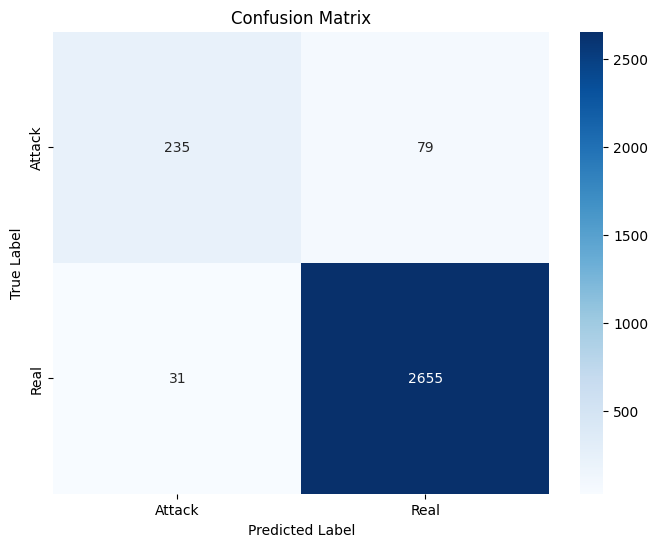

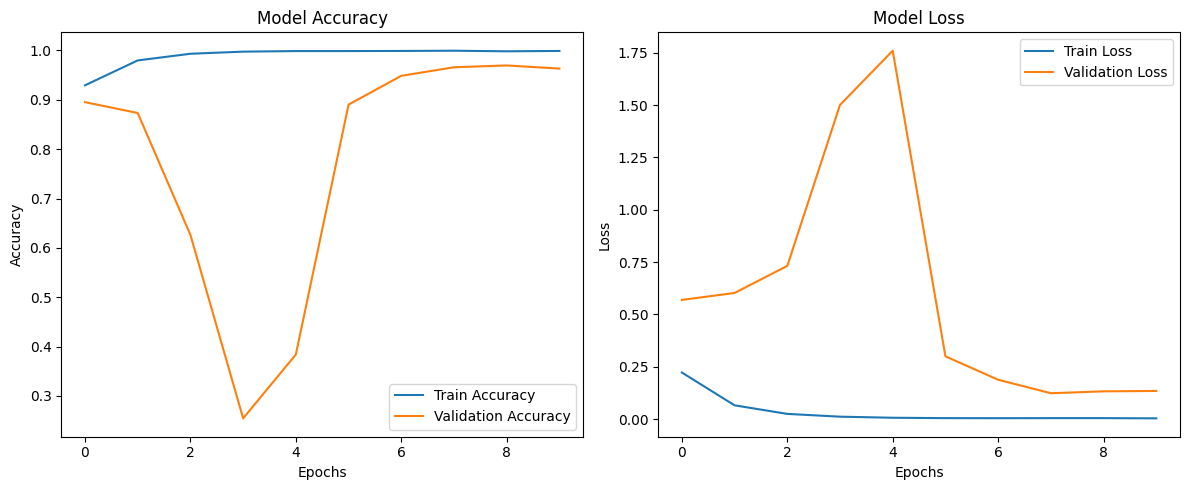

In [9]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from transformers import ViTImageProcessor, ViTForImageClassification
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch

# Enable mixed precision for better GPU performance
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Configure GPU settings
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# Dataset paths
train_dir = '/kaggle/input/lcc-fasd/LCC_FASD/LCC_FASD_training'
val_dir = '/kaggle/input/lcc-fasd/LCC_FASD/LCC_FASD_evaluation'

# Data augmentation and normalization
datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    shuffle=True
)
val_gen = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

# Function to filter data
def filter_data(generator, spoof_count, real_count):
    images, labels = [], []
    for batch_images, batch_labels in tqdm(generator):
        for img, label in zip(batch_images, batch_labels):
            if label == 0 and len(images) < spoof_count:
                images.append(img)
                labels.append(label)
            elif label == 1 and len(images) < (spoof_count + real_count):
                images.append(img)
                labels.append(label)
            if len(images) >= (spoof_count + real_count):
                break
        if len(images) >= (spoof_count + real_count):
            break
    return np.array(images), np.array(labels)

# Filter datasets
train_images, train_labels = filter_data(train_gen, 3000, 1223)  # Use all real images and limit spoof images
val_images, val_labels = filter_data(val_gen, 2700, 300)  # Use all real images and limit spoof images

# Load ViT model and move to GPU
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
vit_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=2)
vit_model.to('cuda:0')  # Ensure the model is on GPU 0

# Function to extract ViT features
def extract_vit_features(images, batch_size=16):
    features = []
    for i in tqdm(range(0, len(images), batch_size)):
        batch_images = images[i:i + batch_size]
        inputs = processor(images=batch_images, return_tensors="pt", do_rescale=False).to('cuda:0')  # Move inputs to GPU
        with torch.no_grad():
            outputs = vit_model(**inputs)
        features.append(outputs.logits.cpu().numpy())
    return np.concatenate(features, axis=0)

# Extract features
vit_features_train = extract_vit_features(train_images)
vit_features_val = extract_vit_features(val_images)

# EfficientNet feature extractor
def efficientnet_features(input_tensor):
    base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model(input_tensor)
    return GlobalAveragePooling2D()(x)

# Model definition
input_tensor = Input(shape=(224, 224, 3))
efficientnet_output = efficientnet_features(input_tensor)
vit_input_tensor = Input(shape=(vit_features_train.shape[-1],))
vit_output_tensor = Dense(256, activation='relu')(vit_input_tensor)

# Combine features
combined_features = Concatenate()([efficientnet_output, vit_output_tensor])
output = Dense(1, activation='sigmoid', dtype='float32')(combined_features)
model = Model(inputs=[input_tensor, vit_input_tensor], outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices(((train_images, vit_features_train), train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices(((val_images, vit_features_val), val_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

# Train the model and save the history
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)

# Evaluate the model
val_predictions = model.predict(val_dataset)
val_predictions = (val_predictions > 0.5).astype(int).flatten()

# Print classification report
print(classification_report(val_labels, val_predictions, target_names=['attack', 'real']))

# Additional evaluation metrics
precision = precision_score(val_labels, val_predictions)
recall = recall_score(val_labels, val_predictions)
f1 = f1_score(val_labels, val_predictions)
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Confusion matrix
conf_matrix = confusion_matrix(val_labels, val_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Attack', 'Real'], yticklabels=['Attack', 'Real'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot training history for accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
